Imports

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, Embedding
from scipy.stats import pearsonr
from keras_self_attention import SeqSelfAttention
import numpy as np
import pandas as pd
import time

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.fillna(0, inplace=True)
    return agg

### Initial Preprocessing

## Baseline LSTM + room to change network architecture

In [8]:
# load dataset
dataset = pd.read_csv('combined_cleaned.csv', header=0, index_col=0)
values = dataset.values
print(dataset.columns)
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
print(values.shape)
# normalize features (after I reframe into a supervised learning problem)
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 1, 1, True)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[7:12], axis=1, inplace=True)
#print(reframed.head())

# split into train and test sets
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 120000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# design network
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(SeqSelfAttention(
    attention_width=15,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Index(['PM2.5', 'Temp', 'RH', 'BP', 'WS', 'WD'], dtype='object')
(156046, 6)
(156046, 12)
(120000, 1, 6) (120000,) (36046, 1, 6) (36046,)


In [9]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)    var4(t-1)  var5(t-1)   var6(t-1)  \
0       0.00   0.000000   0.000000     0.000000       0.00    0.000000   
1      16.75  24.180000  77.389999  1022.099976       0.43  224.880005   
2      21.00  23.940001  78.980003  1022.479980       0.64  217.850006   
3      19.50  23.750000  80.739998  1022.900024       0.61  224.729996   
4      25.25  23.590000  81.870003  1023.200012       0.49  225.779999   

   var1(t)  
0    16.75  
1    21.00  
2    19.50  
3    25.25  
4    31.00  


### Train and Test Neural Network

Epoch 1/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0112 - val_loss: 0.0078
Epoch 2/25
1667/1667 [==============================] - 9s 5ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 3/25
1667/1667 [==============================] - 9s 5ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 4/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 5/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 6/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 7/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 8/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 9/25
1667/1667 [==============================] - 10s 6ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 10/25
1667/1667 [==============================] - 10s 6ms/step - los

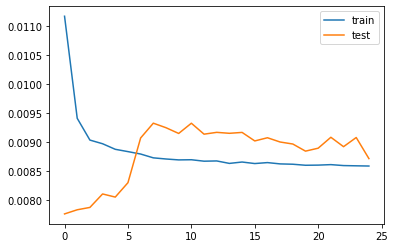

This took 244.76535558700562 seconds.
Test RMSE: 28.623


In [10]:
start = time.time()

# fit network
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE of 25.654 on best run

### Plot Predicted vs. Actual and Calculate Errors

In [11]:
from matplotlib import pyplot as plt

In [12]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 100 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.savefig("lstm_attention.pdf")
    plt.show()

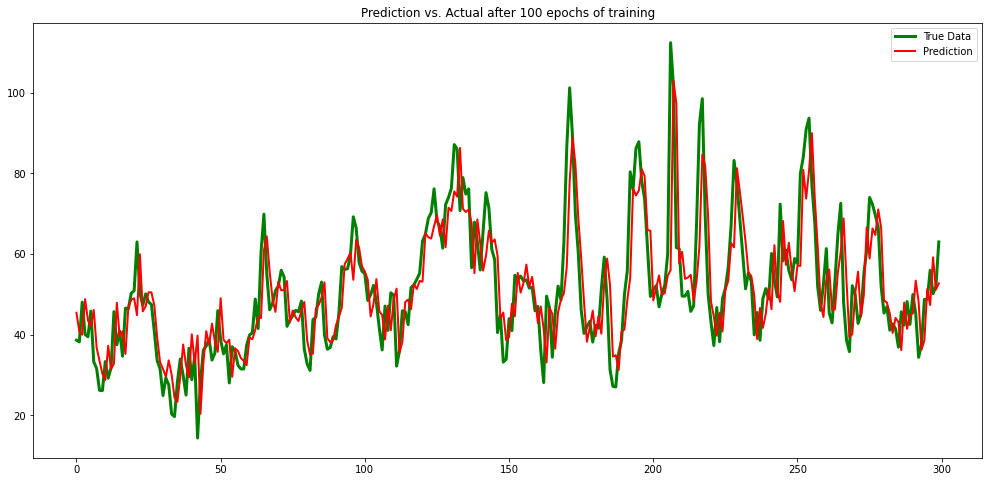

In [13]:
plot_predicted(inv_yhat[:300,], inv_y[:300,])

In [14]:
print('Root Mean Squared Error: {:.4f}'.format(rmse))

#Calculate R^2 (regression score function)
#print('Variance score: %.2f' % r2_score(y, data_pred))
print('Variance score: {:2f}'.format(r2_score(inv_y, inv_yhat)))

Root Mean Squared Error: 28.6228
Variance score: 0.552847


In [15]:
corr, _ = pearsonr(inv_y, inv_yhat)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.767
